In [20]:
import numpy as np
import librosa
import pickle
from numpy.lib import stride_tricks
import ipdb
import os
import matplotlib as mpl
mpl.use('agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
# %matplotlib inline
cmap = cm.get_cmap("Spectral")
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import itertools
import tensorflow as tf
from scipy.io import wavfile

In [15]:
FRAMES_PER_SAMPLE = 100  # number of frames forming a chunk of data
SAMPLING_RATE = 8000
FRAME_SIZE = 256
NEFF = 129  # effective FFT points
# amplification factor of the waveform sig
AMP_FAC = 10000
MIN_AMP = 10000
# TF bins smaller than THRESHOLD will be
# considered inactive
THRESHOLD = 40
# embedding dimention
EMBBEDDING_D = 40
# prams for pre-whitening
GLOBAL_MEAN = 44
GLOBAL_STD = 15.5
p_keep_ff = 1
p_keep_rc = 1

def stft(sig, frameSize, overlapFac=0.75, window=np.hanning):
    """ short time fourier transform of audio signal """
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    # samples = np.append(np.zeros(np.floor(frameSize / 2.0)), sig)
    samples = np.array(sig, dtype='float64')
    # cols for windowing
    cols = int(np.ceil((len(samples) - frameSize) / float(hopSize)))
    # zeros at end (thus samples can be fully covered by frames)
    # samples = np.append(samples, np.zeros(frameSize))
    frames = stride_tricks.as_strided(
        samples,
        shape=(cols, frameSize),
        strides=(samples.strides[0] * hopSize, samples.strides[0])).copy()
    frames *= win
    return np.fft.rfft(frames)

class Model(object):
    def __init__(self, n_hidden, batch_size, p_keep_ff, p_keep_rc):
        '''n_hidden: number of hidden states
           p_keep_ff: forward keep probability
           p_keep_rc: recurrent keep probability'''
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.p_keep_ff = 1
        self.p_keep_rc = 1
        # biases and weights for the last layer
        self.weights = {'out': tf.Variable(tf.random_normal([2 * n_hidden, EMBBEDDING_D * NEFF]))}
        self.biases = {'out': tf.Variable(tf.random_normal([EMBBEDDING_D * NEFF]))}

    def inference(self, x):
        '''The structure of the network'''
        # ipdb.set_trace()
        # four layer of LSTM cell blocks
        with tf.variable_scope('BLSTM1') as scope:
            lstm_fw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc) # by default the activation function is tanh 
            lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(
                lstm_fw_cell, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            lstm_bw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc)
            lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(
                lstm_bw_cell, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            outputs, _ = tf.nn.bidirectional_dynamic_rnn(
                lstm_fw_cell, lstm_bw_cell, x,
                sequence_length=[FRAMES_PER_SAMPLE] * self.batch_size, 
                dtype=tf.float32)
            state_concate = tf.concat(outputs, 2) 
        with tf.variable_scope('BLSTM2') as scope:
            lstm_fw_cell2 = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc)
            lstm_fw_cell2 = tf.nn.rnn_cell.DropoutWrapper(
                lstm_fw_cell2, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            lstm_bw_cell2 = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc)
            lstm_bw_cell2 = tf.nn.rnn_cell.DropoutWrapper(
                lstm_bw_cell2, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            outputs2, _ = tf.nn.bidirectional_dynamic_rnn(
                lstm_fw_cell2, lstm_bw_cell2, state_concate,
                sequence_length=[FRAMES_PER_SAMPLE] * self.batch_size,
                dtype=tf.float32)
            state_concate2 = tf.concat(outputs2, 2)
        with tf.variable_scope('BLSTM3') as scope:
            lstm_fw_cell3 = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc)
            lstm_fw_cell3 = tf.nn.rnn_cell.DropoutWrapper(
                lstm_fw_cell3, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            lstm_bw_cell3 = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc)
            lstm_bw_cell3 = tf.nn.rnn_cell.DropoutWrapper(
                lstm_bw_cell3, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            outputs3, _ = tf.nn.bidirectional_dynamic_rnn(
                lstm_fw_cell3, lstm_bw_cell3, state_concate2,
                sequence_length=[FRAMES_PER_SAMPLE] * self.batch_size,
                dtype=tf.float32)
            state_concate3 = tf.concat(outputs3, 2)
        with tf.variable_scope('BLSTM4') as scope:
            lstm_fw_cell4 = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc)
            lstm_fw_cell4 = tf.nn.rnn_cell.DropoutWrapper(
                lstm_fw_cell4, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            lstm_bw_cell4 = tf.contrib.rnn.LayerNormBasicLSTMCell(
                self.n_hidden, layer_norm=False,
                dropout_keep_prob=self.p_keep_rc)
            lstm_bw_cell4 = tf.nn.rnn_cell.DropoutWrapper(
                lstm_bw_cell4, input_keep_prob=1,
                output_keep_prob=self.p_keep_ff)
            outputs4, _ = tf.nn.bidirectional_dynamic_rnn(
                lstm_fw_cell4, lstm_bw_cell4, state_concate3,
                sequence_length=[FRAMES_PER_SAMPLE] * self.batch_size,
                dtype=tf.float32)
            state_concate4 = tf.concat(outputs4, 2)
        # one layer of embedding output with tanh activation function
        out_concate = tf.reshape(state_concate4, [-1, self.n_hidden * 2])
        emb_out = tf.matmul(out_concate,self.weights['out']) + self.biases['out']
        emb_out = tf.nn.tanh(emb_out)
        reshaped_emb = tf.reshape(emb_out, [-1, NEFF, EMBBEDDING_D])
        # normalization before output
        normalized_emb = tf.nn.l2_normalize(reshaped_emb, 2)
        return normalized_emb

    def loss(self, embeddings, Y, VAD):
        '''Defining the loss function'''
        embeddings_rs = tf.reshape(embeddings, shape=[-1, EMBBEDDING_D])
        VAD_rs = tf.reshape(VAD, shape=[-1])
        # get the embeddings with active VAD
        embeddings_rsv = tf.transpose(tf.multiply(tf.transpose(embeddings_rs), VAD_rs))
        embeddings_v = tf.reshape(embeddings_rsv, [-1, FRAMES_PER_SAMPLE * NEFF, EMBBEDDING_D])
        # get the Y(speaker indicator function) with active VAD
        Y_rs = tf.reshape(Y, shape=[-1, 2])
        Y_rsv = tf.transpose(tf.multiply(tf.transpose(Y_rs), VAD_rs))
        Y_v = tf.reshape(Y_rsv, shape=[-1, FRAMES_PER_SAMPLE * NEFF, 2])
        # fast computation format of the embedding loss function
        loss_batch = tf.nn.l2_loss(tf.matmul(tf.transpose(embeddings_v, [0, 2, 1]), embeddings_v)) - \
            2 * tf.nn.l2_loss(tf.matmul(tf.transpose(embeddings_v, [0, 2, 1]), Y_v)) + \
            tf.nn.l2_loss(tf.matmul(tf.transpose(Y_v, [0, 2, 1]), Y_v))
        
        loss_v = (loss_batch) / self.batch_size
        tf.summary.scalar('loss', loss_v)
        return loss_v

    def train(self, loss, lr):
        '''Optimizer'''
        optimizer = tf.train.AdamOptimizer(learning_rate=lr,beta1=0.9,beta2=0.999,epsilon=1e-8)
        
        gradients, v = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, 200)
        train_op = optimizer.apply_gradients(zip(gradients, v))
        return train_op
    
    
class AudioSampleReader(object):
    '''
    Class AudioSampleReader:
        read in a single audio sample for test using trained model+
    '''
    def __init__(self, data_dir):
        '''Load in the audio file and transform the signal into
        the formats required by the model'''
        # loading and transformation
        speech_mix, _ = librosa.load(data_dir, SAMPLING_RATE)
        speech_mix_spec0 = stft(speech_mix, FRAME_SIZE)[:, :NEFF]
        speech_mix_spec = np.abs(speech_mix_spec0)
        speech_phase = speech_mix_spec0 / speech_mix_spec
        speech_mix_spec = np.maximum(speech_mix_spec, np.max(speech_mix_spec) / MIN_AMP)
        speech_mix_spec = 20. * np.log10(speech_mix_spec * AMP_FAC)
        max_mag = np.max(speech_mix_spec)
        speech_VAD = (speech_mix_spec > (max_mag - THRESHOLD)).astype(int)
        speech_mix_spec = (speech_mix_spec - GLOBAL_MEAN) / GLOBAL_STD
        len_spec = speech_mix_spec.shape[0]
        k = 0
        self.ind = 0
        self.samples = []
        # feed the transformed data into a sample list
        while(k + FRAMES_PER_SAMPLE < len_spec):
            phase = speech_phase[k: k + FRAMES_PER_SAMPLE, :]
            sample_mix = speech_mix_spec[k:k + FRAMES_PER_SAMPLE, :]
            VAD = speech_VAD[k:k + FRAMES_PER_SAMPLE, :]
            sample_dict = {'Sample': sample_mix,
                           'VAD': VAD,
                           'Phase': phase}
            self.samples.append(sample_dict)
            k = k + FRAMES_PER_SAMPLE
        # import ipdb; ipdb.set_trace()
        n_left = FRAMES_PER_SAMPLE - len_spec + k
        # store phase for waveform reconstruction
        phase = np.concatenate((speech_phase[k:, :], np.zeros([n_left, NEFF])))
        sample_mix = np.concatenate((speech_mix_spec[k:, :], np.zeros([n_left, NEFF])))
        VAD = np.concatenate((speech_VAD[k:, :], np.zeros([n_left, NEFF])))
        sample_dict = {'Sample': sample_mix,
                       'VAD': VAD,
                       'Phase': phase}
        self.samples.append(sample_dict)
        self.tot_samp = len(self.samples)

    def gen_next(self):
        begin = self.ind
        if begin >= self.tot_samp:
            return None
        self.ind += 1
        return [self.samples[begin]]
    
lr = 0.00001  # not useful during test
n_hidden = 300  # hidden state size
batch_size = 1  # 1 for audio sample test
hop_size = 64
# oracle flag to decide if a frame need to be seperated
sep_flag = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] * 10
# oracle permutation to concatenate the chuncks of output frames
oracal_p = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] * 10

def out_put(N_frame):
    '''Use trained model to infer N _frame chuncks of
    frames of input audio'''
    with tf.Graph().as_default():
        # feed forward keep prob
        p_keep_ff = tf.placeholder(tf.float32, shape=None)
        # recurrent keep prob
        p_keep_rc = tf.placeholder(tf.float32, shape=None)
        # audio sample generator
        data_generator = AudioSampleReader("mix_male_female.wav")
        # placeholder for model input
        in_data = tf.placeholder(tf.float32, shape=[batch_size, FRAMES_PER_SAMPLE, NEFF])
        # init the model
        BiModel = Model(n_hidden, batch_size, p_keep_ff, p_keep_rc)
        # make inference of embedding
        embedding = BiModel.inference(in_data)
        saver = tf.train.Saver(tf.all_variables())
        sess = tf.Session()
        # restore the model
        saver.restore(sess, 'train/trained/model.ckpt')
        tot_frame = N_frame * FRAMES_PER_SAMPLE
        # arrays to store output waveform
        out_audio1 = np.zeros([(tot_frame - 1) * hop_size + FRAME_SIZE])
        out_audio2 = np.zeros([(tot_frame - 1) * hop_size + FRAME_SIZE])
        mix = np.zeros([(tot_frame - 1) * hop_size + FRAME_SIZE])
        N_assign = 0

        # for every chunk of frames of data
        for step in range(N_frame):
            # import ipdb; ipdb.set_trace()
            data_batch = data_generator.gen_next()
            if data_batch is None:
                break
            # log spectrum info.
            in_data_np = np.concatenate([np.reshape(item['Sample'], [1, FRAMES_PER_SAMPLE, NEFF]) for item in data_batch])
            # phase info.
            in_phase_np = np.concatenate([np.reshape(item['Phase'], [1, FRAMES_PER_SAMPLE, NEFF]) for item in data_batch])
            # VAD info.
            VAD_data_np = np.concatenate([np.reshape(item['VAD'], [1, FRAMES_PER_SAMPLE, NEFF]) for item in data_batch])

            # get inferred embedding using trained model
            embedding_np, = sess.run([embedding],feed_dict={in_data: in_data_np,p_keep_ff: 1,p_keep_rc: 1})
            # get active TF-bin embedding according to VAD
            embedding_ac = [embedding_np[i, j, :]
                            for i, j in itertools.product(
                                range(FRAMES_PER_SAMPLE), range(NEFF))
                            if VAD_data_np[0, i, j] == 1]
            if(sep_flag[step] == 1):
                # if the frame need to be seperated
                # cluster the embeddings
                if embedding_ac == []:
                    break
                kmean = KMeans(n_clusters=2, random_state=0).fit(embedding_ac)

            else:
                # if the frame don't need to be seperated
                # don't split the embeddings
                kmean = KMeans(n_clusters=1, random_state=0).fit(embedding_ac)
            mask = np.zeros([FRAMES_PER_SAMPLE, NEFF, 2])
            ind = 0
            if N_assign == 0:
                # if their is no existing speaker in previous frame
                center = kmean.cluster_centers_
                N_assign = center.shape[0]
            elif N_assign == 1:
                # if their is one speaker in previous frame
                center_new = kmean.cluster_centers_
                # assign the embedding for a speaker to the speaker with the
                # closest centroid in previous frames
                if center_new.shape[0] == 1:
                    # update and smooth the centroid for 1 speaker
                    center = 0.7 * center + 0.3 * center_new
                else:
                    # update and smooth the centroid for 2 speakers
                    N_assign = 2
                    # compute their relative affinity
                    cor = np.matmul(center_new, np.transpose(center))
                    # ipdb.set_trace()
                    if(cor[1] > cor[0]):
                        # rearrange their sequence if not consistant with
                        # previous frames
                        kmean.cluster_centers_ = np.array([kmean.cluster_centers_[1],kmean.cluster_centers_[0]])
                        kmean.labels_ = (kmean.labels_ == 0).astype('int')
                    center = kmean.cluster_centers_
            else:
                # two speakers have appeared
                center_new = kmean.cluster_centers_
                cor = np.matmul(center_new[0, :], np.transpose(center))
                # rearrange their sequence if not consistant with previous
                # frames
                if(cor[1] > cor[0]):
                    if(sep_flag[step] == 1):
                        kmean.cluster_centers_ = np.array([kmean.cluster_centers_[1],kmean.cluster_centers_[0]])
                        kmean.labels_ = (kmean.labels_ == 0).astype('int')
                    else:
                        kmean.labels_ = (kmean.labels_ == 1).astype('int')
                # need permutation of their order(Oracle)
                if(oracal_p[step]):
                    kmean.cluster_centers_ = np.array([kmean.cluster_centers_[1],kmean.cluster_centers_[0]])
                    kmean.labels_ = (kmean.labels_ == 0).astype('int')
                else:
                    kmean.labels_ = (~kmean.labels_).astype('int')
                center = center * 0.7 + 0.3 * kmean.cluster_centers_

            # transform the clustering result and VAD info. into masks
            for i in range(FRAMES_PER_SAMPLE):
                for j in range(NEFF):
                    if VAD_data_np[0, i, j] == 1:
                        mask[i, j, kmean.labels_[ind]] = 1
                        ind += 1
            for i in range(FRAMES_PER_SAMPLE):
                # apply the mask and reconstruct the waveform
                tot_ind = step * FRAMES_PER_SAMPLE + i
                amp = in_data_np[0, i, :] * GLOBAL_STD + GLOBAL_MEAN
                out_data1 = (mask[i, :, 0] * amp * VAD_data_np[0, i, :])
                out_data2 = (mask[i, :, 1] * amp * VAD_data_np[0, i, :])
                out_mix = amp
                out_data1_l = 10 ** (out_data1 / 20) / AMP_FAC
                out_data2_l = 10 ** (out_data2 / 20) / AMP_FAC
                out_mix_l = 10 ** (out_mix / 20) / AMP_FAC

                out_stft1 = out_data1_l * in_phase_np[0, i, :]
                out_stft2 = out_data2_l * in_phase_np[0, i, :]
                out_stft_mix = out_mix_l * in_phase_np[0, i, :]

                con_data1 = out_stft1[-2:0:-1].conjugate()
                con_data2 = out_stft2[-2:0:-1].conjugate()
                con_mix = out_stft_mix[-2:0:-1].conjugate()

                out1 = np.concatenate((out_stft1, con_data1))
                out2 = np.concatenate((out_stft2, con_data2))
                out_mix = np.concatenate((out_stft_mix, con_mix))
                frame_out1 = np.fft.ifft(out1).astype(np.float64)
                frame_out2 = np.fft.ifft(out2).astype(np.float64)
                frame_mix = np.fft.ifft(out_mix).astype(np.float64)

                out_audio1[tot_ind * hop_size:tot_ind * hop_size + FRAME_SIZE] += frame_out1 * 0.5016
                out_audio2[tot_ind * hop_size:tot_ind * hop_size + FRAME_SIZE] += frame_out2 * 0.5016
                mix[tot_ind * hop_size:tot_ind * hop_size + FRAME_SIZE] += frame_mix * 0.5016

        librosa.output.write_wav('out_mix_male_female1.wav', out_audio1, SAMPLING_RATE)
        librosa.output.write_wav('out_mix_male_female2.wav', out_audio2, SAMPLING_RATE)

In [16]:
n_hidden = 300
batch_size = 1

In [17]:
data_dir = []
data_dir.append('misc/mix_male_female.wav')

In [18]:
def visualize3D(N_frame,file):
    with tf.Graph().as_default():
        data_dir = file
        # init the sample reader
        data_generator = AudioSampleReader(data_dir)
        # build the graph as the training script
        in_data = tf.placeholder(
            tf.float32, shape=[batch_size, FRAMES_PER_SAMPLE, NEFF])
        VAD_data = tf.placeholder(
            tf.float32, shape=[batch_size, FRAMES_PER_SAMPLE, NEFF])
        Y_data = tf.placeholder(
            tf.float32, shape=[batch_size, FRAMES_PER_SAMPLE, NEFF, 2])
        # init
        BiModel = Model(n_hidden, batch_size, p_keep_ff, p_keep_rc)
        # infer embedding
        embedding = BiModel.inference(in_data)
        saver = tf.train.Saver(tf.all_variables())
        sess = tf.Session()
        # restore a model
        saver.restore(sess, 'train/trained/model.ckpt')

        for step in range(N_frame):
            data_batch = data_generator.gen_next()
            if data_batch is None:
                break
            # concatenate the elements in sample dict to generate batch data
            in_data_np = np.concatenate([np.reshape(item['Sample'], [1, FRAMES_PER_SAMPLE, NEFF]) for item in data_batch])
            VAD_data_np = np.concatenate([np.reshape(item['VAD'], [1, FRAMES_PER_SAMPLE, NEFF]) for item in data_batch])
            embedding_np, = sess.run([embedding],feed_dict={in_data: in_data_np,VAD_data: VAD_data_np})
            # only plot those embeddings whose VADs are active
            embedding_ac = [embedding_np[i, j, :]
                            for i, j in itertools.product(
                                range(FRAMES_PER_SAMPLE), range(NEFF))
                            if VAD_data_np[0, i, j] == 1]

            kmean = KMeans(n_clusters=3, random_state=0).fit(embedding_ac)
            # visualization using 3 PCA
            pca_Data = PCA(n_components=3).fit_transform(embedding_ac)
            fig = plt.figure(1, figsize=(8, 6))
            ax = Axes3D(fig, elev=-150, azim=110)
            labels = kmean.labels_
            ax.scatter(pca_Data[:,0],pca_Data[:,1],pca_Data[:,2], c=labels , cmap='Set2', s=70)
            ax.set_xlabel('1st pc')
            ax.set_ylabel('2nd pc')
            ax.set_zlabel('3rd pc')

            plt.show()

INFO:tensorflow:Restoring parameters from train/trained/model.ckpt


C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI back

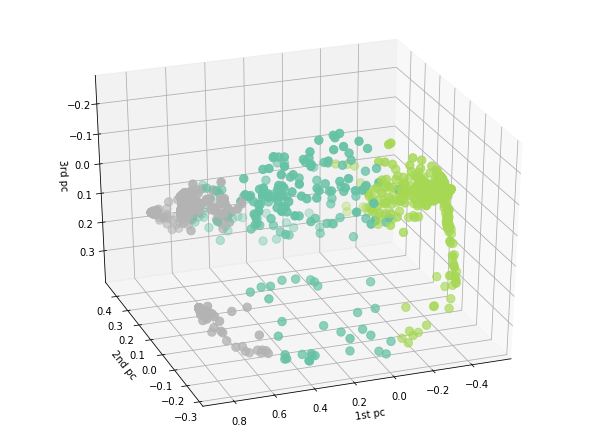

In [21]:
visualize3D(10, data_dir[0])

In [7]:
def visualize2D(N_frame,file):
    with tf.Graph().as_default():
        data_dir = file
        # init the sample reader
        data_generator = AudioSampleReader(data_dir)
        # build the graph as the training script
        in_data = tf.placeholder(
            tf.float32, shape=[batch_size, FRAMES_PER_SAMPLE, NEFF])
        VAD_data = tf.placeholder(
            tf.float32, shape=[batch_size, FRAMES_PER_SAMPLE, NEFF])
        Y_data = tf.placeholder(
            tf.float32, shape=[batch_size, FRAMES_PER_SAMPLE, NEFF, 2])
        # init
        BiModel = Model(n_hidden, batch_size, p_keep_ff, p_keep_rc)
        # infer embedding
        embedding = BiModel.inference(in_data)
        saver = tf.train.Saver(tf.all_variables())
        sess = tf.Session()
        # restore a model
        saver.restore(sess, 'train/trained/model.ckpt')

        for step in range(N_frame):
            data_batch = data_generator.gen_next()
            if data_batch is None:
                break
            # concatenate the elements in sample dict to generate batch data
            in_data_np = np.concatenate([np.reshape(item['Sample'], [1, FRAMES_PER_SAMPLE, NEFF]) for item in data_batch])
            VAD_data_np = np.concatenate([np.reshape(item['VAD'], [1, FRAMES_PER_SAMPLE, NEFF]) for item in data_batch])
            embedding_np, = sess.run([embedding],feed_dict={in_data: in_data_np,VAD_data: VAD_data_np})
            # only plot those embeddings whose VADs are active
            embedding_ac = [embedding_np[i, j, :]
                            for i, j in itertools.product(
                                range(FRAMES_PER_SAMPLE), range(NEFF))
                            if VAD_data_np[0, i, j] == 1]

            kmean = KMeans(n_clusters=3, random_state=0).fit(embedding_ac)
            # visualization using 3 PCA
            pca_Data = PCA(n_components=3).fit_transform(embedding_ac)
            fig = plt.figure(1, figsize=(8, 6))
            labels = kmean.labels_
            ax = plt.axes(projection = 'rectilinear', )
            ax.scatter(pca_Data[:,0],pca_Data[:,1],pca_Data[:,2], c=labels , cmap='gist_heat')

            plt.show()

INFO:tensorflow:Restoring parameters from train/trained/model.ckpt


C:\Users\91828\Anaconda3\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\91828\Anaconda3\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\91828\Anaconda3\lib\site-packages\ipykernel_launcher.py:

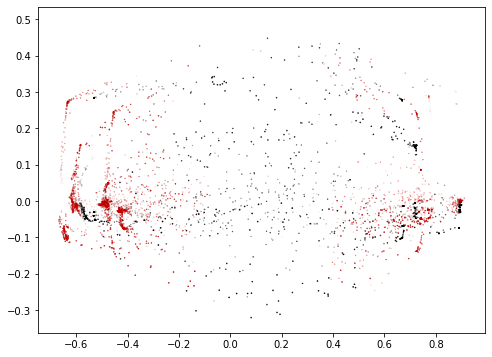

In [22]:
visualize2D(10, data_dir[0])